# Importamos las librerias a usar

In [1]:
# !pip3 install --upgrade wandb

In [2]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import sklearn
import os
import time

2025-09-28 06:16:55.651218: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-28 06:16:55.676443: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-28 06:16:55.122403: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from keras import layers
from keras import initializers
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras import regularizers
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping

# Preparación

La solución de la ec. diferencial es y(x) = x*sen(x) - (2*sen(x))/x + 2*cos(x) + C/x, para valores muy pequeños de x tenemos y(x) = x^2 - 2x/x + 2 + C/x = x^2 + C/x si hacemos C = 0 entonces y(0) = 0 para valores pequeños de x. de otro modo en 0 la solución se va a infinito en 0. Ppor otro lado para evitar problemas de entrenamiento en la red aproximaremos el x_0<<1 y no a 0.

## Creamos la clase para resolver la ecuación diferencial

In [4]:
class ODEsolver(Sequential):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.mse = tf.keras.losses.MeanSquaredError()

    @property
    def metrics(self):
      return [self.loss_tracker]

    def train_step(self, data):
         batch_size = tf.shape(data)[0]
         min = tf.cast(tf.reduce_min(data),tf.float32)
         max = tf.cast(tf.reduce_max(data),tf.float32)
         x = tf.random.uniform((batch_size,1), minval=min, maxval=max)

         with tf.GradientTape() as tape:
             with tf.GradientTape() as tape2:
                 tape2.watch(x)
                 y_pred = self(x, training=True)
             dy = tape2.gradient(y_pred, x) #derivada del modelo con respecto a entradas x
             x_o = tf.zeros((batch_size,1)) #valor de x en condicion inicial x_0=0
             y_o = self(x_o,training=True) #valor del modelo en en x_0
             eq = x*dy + y_pred - (x**2)*tf.cos(x) #Ecuacion diferencial evaluada en el modelo. Queremos que sea muy pequeno
             ic = 0.00001 #valor que queremos para la condicion inicial o el modelo en x_0
             loss = self.mse(0., eq) + self.mse(y_o,ic)

        # Apply grads
         grads = tape.gradient(loss, self.trainable_variables)
         self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        #update metrics
         self.loss_tracker.update_state(loss)
        # Return a dict mapping metric names to current value
         return {"loss": self.loss_tracker.result()}

# Creación de la red neuronal

In [5]:
model = ODEsolver()
model.add(Dense(100, activation='tanh', input_shape=(1,)))
model.add(Dense(20, activation='tanh'))
model.add(Dense(1))
model.summary()

Model: "od_esolver"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 100)            │           200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │         2,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,241 (8.75 KB)

 Trainable params: 2,241 (8.75 KB)

 Non-trainable params: 0 (0.00 B)

## Observamos el comportamiento del loss

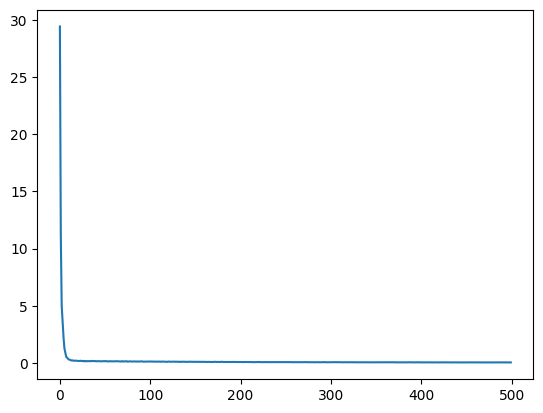

In [6]:
model.compile(optimizer=RMSprop(),metrics=['loss'])
divisions = 5000
x = tf.linspace(-5,5,divisions)
history = model.fit(x,epochs=500,verbose=0)
plt.plot(history.history["loss"])

## Entrenamos el modelo y visualizamos

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step


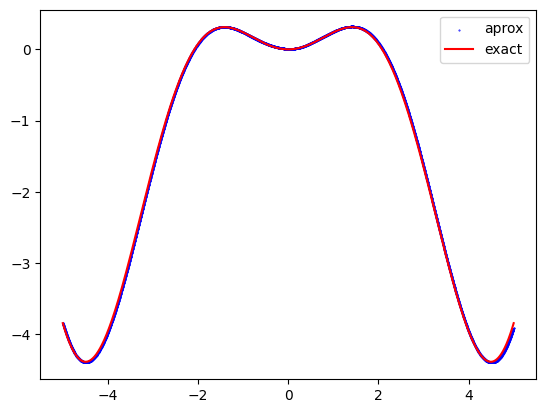

In [7]:
x_testv = tf.linspace(-5,5,divisions)
x = x_testv
a=model.predict(x_testv)
plt.scatter(x_testv,a,label="aprox", s = 0.2, color = "blue")
plt.plot(x_testv, x*np.sin(x)-(2*np.sin(x))/x + 2*np.cos(x),label="exact", color = "red")
plt.legend()
plt.show()